In [1]:
import time
import os
import random
import math

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from PIL import Image, ImageOps

import progressbar

plt.ion()   # interactive mode

In [2]:
### Some utilities

In [3]:
def to_2d_tensor(inp):
    inp = torch.Tensor(inp)
    if len(inp.size()) < 2:
        inp = inp.unsqueeze(0)
    return inp

def xywh_to_x1y1x2y2(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] += boxes[:, 0] - 1
    boxes[:, 3] += boxes[:, 1] - 1
    return boxes

def x1y1x2y2_to_xywh(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] -= boxes[:, 0] - 1
    boxes[:, 3] -= boxes[:, 1] - 1
    return boxes

def crop_boxes(boxes, im_sizes):
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes = xywh_to_x1y1x2y2(boxes)
    zero = torch.Tensor([0])
    boxes[:, 0] = torch.max(torch.min(boxes[:, 0], im_sizes[:, 0]), zero)
    boxes[:, 1] = torch.max(torch.min(boxes[:, 1], im_sizes[:, 1]), zero)
    boxes[:, 2] = torch.max(torch.min(boxes[:, 2], im_sizes[:, 0]), zero)
    boxes[:, 3] = torch.max(torch.min(boxes[:, 3], im_sizes[:, 1]), zero)
    boxes = x1y1x2y2_to_xywh(boxes)
    return boxes

def box_transform(boxes, im_sizes):
    # box in (x, y, w, h) format
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes[:, 0] = 2 * boxes[:, 0] / im_sizes[:, 0] - 1
    boxes[:, 1] = 2 * boxes[:, 1] / im_sizes[:, 1] - 1
    boxes[:, 2] = 2 * boxes[:, 2] / im_sizes[:, 0]
    boxes[:, 3] = 2 * boxes[:, 3] / im_sizes[:, 1]
    return boxes

def box_transform_inv(boxes, im_sizes):
    # box in (x, y, w, h) format
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes[:, 0] = (boxes[:, 0] + 1) / 2 * im_sizes[:, 0]
    boxes[:, 1] = (boxes[:, 1] + 1) / 2 * im_sizes[:, 1]
    boxes[:, 2] = boxes[:, 2] / 2 * im_sizes[:, 0]
    boxes[:, 3] = boxes[:, 3] / 2 * im_sizes[:, 1]
    return boxes

def compute_IoU(boxes1, boxes2):
    boxes1 = to_2d_tensor(boxes1)
    boxes1 = xywh_to_x1y1x2y2(boxes1)
    boxes2 = to_2d_tensor(boxes2)
    boxes2 = xywh_to_x1y1x2y2(boxes2)
    
    intersec = boxes1.clone()
    intersec[:, 0] = torch.max(boxes1[:, 0], boxes2[:, 0])
    intersec[:, 1] = torch.max(boxes1[:, 1], boxes2[:, 1])
    intersec[:, 2] = torch.min(boxes1[:, 2], boxes2[:, 2])
    intersec[:, 3] = torch.min(boxes1[:, 3], boxes2[:, 3])
    
    def compute_area(boxes):
        # in (x1, y1, x2, y2) format
        dx = boxes[:, 2] - boxes[:, 0]
        dx[dx < 0] = 0
        dy = boxes[:, 3] - boxes[:, 1]
        dy[dy < 0] = 0
        return dx * dy
    
    a1 = compute_area(boxes1)
    a2 = compute_area(boxes2)
    ia = compute_area(intersec)
    assert((a1 + a2 - ia <= 0).sum() == 0)
    
    return ia / (a1 + a2 - ia)    

def compute_acc(preds, targets, im_sizes, theta=0.75):
    preds = box_transform_inv(preds.clone(), im_sizes)
    preds = crop_boxes(preds, im_sizes)
    targets = box_transform_inv(targets.clone(), im_sizes)
    IoU = compute_IoU(preds, targets)
    corr = (IoU >= theta).sum()
    return corr.item() / preds.size(0)

class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        
def imshow(img, gt_box, pred_box=None):
    plt.imshow(img)
    
    def draw_box(box, color='green'):
        x, y, w, h = box_transform_inv(box, img.shape[:2][::-1])[0]
        if x == 0:
            x = 1
        if y == 0:
            y = 1
        plt.gca().add_patch(
            plt.Rectangle((x, y), w, h,
                          fill=False, edgecolor=color, linewidth=2, alpha=0.5)
        )
        
    draw_box(gt_box)
    if pred_box is not None:
        draw_box(pred_box, 'red')

### Split dataset

In [4]:
def split(ratio):
    with open('data/images.txt') as f:
        lines = f.read().splitlines()
    class_groups = dict()
    for line in lines:
        value, line = line.split(' ', 1)
        key = line.split('.', 1)[0]
        value = value
        if key in class_groups:
            class_groups[key].append(value)
        else:
            class_groups[key] = [value]
            
    test_id = []
    for _, group in class_groups.items():
        test_id.extend(random.sample(group, int(math.ceil(len(group)*ratio))))
    train_id = [i for i in map(str, range(1, len(lines)+1)) if i not in test_id]
    
    return train_id, test_id
# split返回两个id的tuple
train_id, test_id = split(0.2)

In [5]:
class MyResize(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    def __call__(self, sample):
        image, box = sample['image'], sample['box']
        return {'image':transforms.Resize(self.output_size)(image), 'box':box}
    
class MyToTensor(object):
    def __call__(self, sample):
        image, box = sample['image'], sample['box']
        return {'image': transforms.ToTensor()(image), 'box': box}
    
class MyNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        image, box = sample['image'], sample['box']
        return {'image': transforms.Normalize(self.mean, self.std)(image), 'box': box}


class MyRandomVerticalFlip(object):
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, sample):
        image, box = sample['image'], sample['box']
        if random.random() < self.p:
            im_size = np.array(image.size, dtype='float32')
            box[1] = im_size[1] - (box[1] + box[3])
            return {'image': image.transpose(Image.FLIP_TOP_BOTTOM), 'box':box}
        return {'image':image, 'box':box}
    
class MyRandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, sample):
        image, box = sample['image'], sample['box']
        if random.random() < self.p:
            im_size = np.array(image.size, dtype='float32')
            box[0] = im_size[0] - (box[0] + box[2])
            return {'image':image.transpose(Image.FLIP_LEFT_RIGHT),'box':box}
        return {'image':image, 'box':box}

class MyRandomGrayscale(object):
    def __init__(self, p=0.1):
        self.p = p
    def __call__(self, sample):
        image, box = sample['image'], sample['box']
        if random.random() < self.p:
            return {'image':transforms.RandomGrayscale(self.p)(image),'box':box}
        return {'image':image, 'box':box}
    
# def MyRandomVerticalFlip(sample, p=0.5):
#     image, box = sample['image'], sample['box']
#     if random.random() < p:
#         im_size = np.array(image.size, dtype='float32')
#         box[1] = im_size[1] - (box[1] + box[3])
#         return image.transpose(Image.FLIP_TOP_BOTTOM), box
#     return image, box
# def MyRandomHorizontalFlip(sample, p=0.5):
#     image, box = sample['image'], sample['box']
#     if random.random() < p:
#         im_size = np.array(image.size, dtype='float32')
#         box[0] = im_size[0] - (box[0] + box[2])
#         return image.transpose(Image.FLIP_LEFT_RIGHT), box
#     return image, box

In [6]:
class CUBDataset(Dataset):
    def __init__(self, im_ids, transform=None):
        with open('data/images.txt') as f:
            id_to_path = dict([l.split(' ', 1) for l in f.read().splitlines()])
        with open('data/bounding_boxes.txt') as f:
            id_to_box = dict()
            for line in f.read().splitlines():
                im_id, *box = line.split(' ')
                id_to_box[im_id] = list(map(float, box))
        self.imgs = [(os.path.join('data/images', id_to_path[i]), id_to_box[i])
                     for i in im_ids]
        #print(self.imgs[0][1])
        if transform is None:
            if im_ids == train_id:
                self.transform = transforms.Compose([
                    #transforms.Resize(224),
                    #transforms.RandomVerticalFlip(),
                    #transforms.RandomHorizontalFlip(),
                    #transforms.RandomGrayscale(0.2),
                    #transforms.ToTensor(),
                    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    MyRandomVerticalFlip(),
                    MyRandomHorizontalFlip(),
                    MyResize((224,224)),
                    MyRandomGrayscale(),
                    MyToTensor(),
                    MyNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
            else:
                self.transform = transforms.Compose([
                    MyResize((224,224)),
                    MyToTensor(),
                    MyNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#                     transforms.Resize(224),
#                     transforms.ToTensor(),
#                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
        else:
            self.transform = transform
            
    def __getitem__(self, index):
        path, box = self.imgs[index]
        im = Image.open(path).convert('RGB')
        im_size = np.array(im.size, dtype='float32')
        box = np.array(box, dtype='float32')
        
        sample = {'image': im, 'box': box}
#         im, box = MyRandomHorizontalFlip(sample)
#         sample = {'image': im, 'box': box}
#         im, box = MyRandomHorizontalFlip(sample)
        
        sample = self.transform(sample)
        return sample['image'], sample['box'], im_size
        #return im, box, im_size
    
    def __len__(self):
        return len(self.imgs)
    

In [7]:
### Define Dataset

In [8]:
splits = {'train': train_id, 'test': test_id}
datasets = {split: CUBDataset(splits[split]) for split in ('train', 'test')}

### Visualize training data

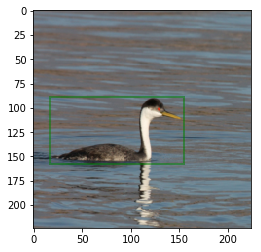

In [9]:
ind = random.choice(range(len(datasets['train'])))
im, box, im_size = datasets['train'][ind]
box = box_transform(box, im_size)
inp = im.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)

imshow(inp, box[0])

### Training

In [10]:
# prepare data
dataloaders = {split: torch.utils.data.DataLoader(
                datasets[split], batch_size=32,shuffle=(split=='train'),
                num_workers=4, pin_memory=True) for split in ('train', 'test')}

# construct model
model = models.resnet18(pretrained=True)
fc_in_size = model.fc.in_features
model.fc = nn.Linear(fc_in_size, 4)
model = model.cuda()
criterion = nn.SmoothL1Loss().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

best_model_state = model.state_dict()
best_epoch = -1
best_acc = 0.0

epoch_loss = {'train': [], 'test': []}
epoch_acc = {'train': [], 'test': []}
epochs = 20
for epoch in range(20):
    accs = AverageMeter()
    losses = AverageMeter()
    for phase in ('train', 'test'):
        if phase == 'train':
            scheduler.step()
            model.train(True)
        else:
            model.train(False)
            
        end = time.time()
        bar = progressbar.ProgressBar()
        for ims, boxes, im_sizes in bar(dataloaders[phase]):
            boxes = crop_boxes(boxes, im_sizes)
            boxes = box_transform(boxes, im_sizes)
            
            inputs = Variable(ims.cuda())
            targets = Variable(boxes.cuda())
            
            optimizer.zero_grad()
            
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            acc = compute_acc(outputs.data.cpu(), targets.data.cpu(), im_sizes)
            
            nsample = inputs.size(0)
            accs.update(acc, nsample)
            losses.update(loss.data[0], nsample)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()
        
        if phase == 'test' and accs.avg > best_acc:
            best_acc = accs.avg
            best_epoch = epoch
            best_model_state = model.state_dict()
            
        elapsed_time = time.time() - end
        print('[{}]\tEpoch: {}/{}\tLoss: {:.4f}\tAcc: {:.2%}\tTime: {:.3f}'.format(
            phase, epoch+1, epochs, losses.avg, accs.avg, elapsed_time))
        epoch_loss[phase].append(losses.avg)
        epoch_acc[phase].append(accs.avg)
        
    print('[Info] best test acc: {:.2%} at {}th epoch'.format(best_acc, best_epoch+1))
    torch.save(best_model_state, 'best_model_state.path.tar')

N/A% (0 of 295) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:51: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
100% (295 of 295) |######################| Elapsed Time: 0:04:13 Time:  0:04:13


[train]	Epoch: 1/20	Loss: 0.0399	Acc: 13.26%	Time: 254.869


100% (75 of 75) |########################| Elapsed Time: 0:01:01 Time:  0:01:01


[test]	Epoch: 1/20	Loss: 0.0358	Acc: 16.46%	Time: 65.338
[Info] best test acc: 16.46% at 1th epoch


100% (295 of 295) |######################| Elapsed Time: 0:03:57 Time:  0:03:57


[train]	Epoch: 2/20	Loss: 0.0146	Acc: 33.00%	Time: 240.127


100% (75 of 75) |########################| Elapsed Time: 0:00:50 Time:  0:00:50


[test]	Epoch: 2/20	Loss: 0.0141	Acc: 34.47%	Time: 54.108
[Info] best test acc: 34.47% at 2th epoch


100% (295 of 295) |######################| Elapsed Time: 0:03:58 Time:  0:03:58


[train]	Epoch: 3/20	Loss: 0.0118	Acc: 39.44%	Time: 242.015


100% (75 of 75) |########################| Elapsed Time: 0:00:54 Time:  0:00:54


[test]	Epoch: 3/20	Loss: 0.0121	Acc: 41.19%	Time: 57.993
[Info] best test acc: 41.19% at 3th epoch


100% (295 of 295) |######################| Elapsed Time: 0:03:59 Time:  0:03:59


[train]	Epoch: 4/20	Loss: 0.0107	Acc: 44.03%	Time: 242.435


100% (75 of 75) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


[test]	Epoch: 4/20	Loss: 0.0103	Acc: 46.17%	Time: 55.166
[Info] best test acc: 46.17% at 4th epoch


100% (295 of 295) |######################| Elapsed Time: 0:03:58 Time:  0:03:58


[train]	Epoch: 5/20	Loss: 0.0089	Acc: 51.29%	Time: 241.809


100% (75 of 75) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


[test]	Epoch: 5/20	Loss: 0.0093	Acc: 47.62%	Time: 54.615
[Info] best test acc: 47.62% at 5th epoch


100% (295 of 295) |######################| Elapsed Time: 0:03:59 Time:  0:03:59


[train]	Epoch: 6/20	Loss: 0.0053	Acc: 75.86%	Time: 242.827


100% (75 of 75) |########################| Elapsed Time: 0:00:50 Time:  0:00:50


[test]	Epoch: 6/20	Loss: 0.0052	Acc: 76.47%	Time: 54.045
[Info] best test acc: 76.47% at 6th epoch


100% (295 of 295) |######################| Elapsed Time: 0:03:58 Time:  0:03:58


[train]	Epoch: 7/20	Loss: 0.0043	Acc: 80.05%	Time: 241.828


100% (75 of 75) |########################| Elapsed Time: 0:00:50 Time:  0:00:50


[test]	Epoch: 7/20	Loss: 0.0044	Acc: 80.33%	Time: 54.154
[Info] best test acc: 80.33% at 7th epoch


100% (295 of 295) |######################| Elapsed Time: 0:03:59 Time:  0:03:59


[train]	Epoch: 8/20	Loss: 0.0039	Acc: 81.30%	Time: 242.921


100% (75 of 75) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


[test]	Epoch: 8/20	Loss: 0.0040	Acc: 81.37%	Time: 54.394
[Info] best test acc: 81.37% at 8th epoch


100% (295 of 295) |######################| Elapsed Time: 0:03:58 Time:  0:03:58


[train]	Epoch: 9/20	Loss: 0.0036	Acc: 82.84%	Time: 242.062


100% (75 of 75) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


[test]	Epoch: 9/20	Loss: 0.0038	Acc: 82.90%	Time: 54.396
[Info] best test acc: 82.90% at 9th epoch


100% (295 of 295) |######################| Elapsed Time: 0:04:00 Time:  0:04:00


[train]	Epoch: 10/20	Loss: 0.0034	Acc: 83.93%	Time: 244.166


100% (75 of 75) |########################| Elapsed Time: 0:00:50 Time:  0:00:50


[test]	Epoch: 10/20	Loss: 0.0036	Acc: 83.29%	Time: 54.347
[Info] best test acc: 83.29% at 10th epoch


100% (295 of 295) |######################| Elapsed Time: 0:04:01 Time:  0:04:01


[train]	Epoch: 11/20	Loss: 0.0029	Acc: 86.74%	Time: 244.404


100% (75 of 75) |########################| Elapsed Time: 0:00:50 Time:  0:00:50


[test]	Epoch: 11/20	Loss: 0.0031	Acc: 86.26%	Time: 54.009
[Info] best test acc: 86.26% at 11th epoch


100% (295 of 295) |######################| Elapsed Time: 0:04:00 Time:  0:04:00


[train]	Epoch: 12/20	Loss: 0.0028	Acc: 87.14%	Time: 244.078


100% (75 of 75) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


[test]	Epoch: 12/20	Loss: 0.0030	Acc: 86.66%	Time: 54.874
[Info] best test acc: 86.66% at 12th epoch


100% (295 of 295) |######################| Elapsed Time: 0:04:01 Time:  0:04:01


[train]	Epoch: 13/20	Loss: 0.0027	Acc: 87.20%	Time: 244.658


100% (75 of 75) |########################| Elapsed Time: 0:00:50 Time:  0:00:50


[test]	Epoch: 13/20	Loss: 0.0030	Acc: 86.68%	Time: 54.198
[Info] best test acc: 86.68% at 13th epoch


100% (295 of 295) |######################| Elapsed Time: 0:03:59 Time:  0:03:59


[train]	Epoch: 14/20	Loss: 0.0027	Acc: 87.04%	Time: 242.804


100% (75 of 75) |########################| Elapsed Time: 0:00:50 Time:  0:00:50


[test]	Epoch: 14/20	Loss: 0.0029	Acc: 86.76%	Time: 54.158
[Info] best test acc: 86.76% at 14th epoch


100% (295 of 295) |######################| Elapsed Time: 0:03:59 Time:  0:03:59


[train]	Epoch: 15/20	Loss: 0.0026	Acc: 87.44%	Time: 242.012


100% (75 of 75) |########################| Elapsed Time: 0:00:50 Time:  0:00:50


[test]	Epoch: 15/20	Loss: 0.0029	Acc: 86.99%	Time: 53.956
[Info] best test acc: 86.99% at 15th epoch


100% (295 of 295) |######################| Elapsed Time: 0:04:00 Time:  0:04:00


[train]	Epoch: 16/20	Loss: 0.0026	Acc: 87.76%	Time: 243.249


100% (75 of 75) |########################| Elapsed Time: 0:00:50 Time:  0:00:50


[test]	Epoch: 16/20	Loss: 0.0028	Acc: 87.27%	Time: 53.942
[Info] best test acc: 87.27% at 16th epoch


100% (295 of 295) |######################| Elapsed Time: 0:04:00 Time:  0:04:00


[train]	Epoch: 17/20	Loss: 0.0026	Acc: 88.35%	Time: 243.357


100% (75 of 75) |########################| Elapsed Time: 0:00:50 Time:  0:00:50


[test]	Epoch: 17/20	Loss: 0.0028	Acc: 87.63%	Time: 53.827
[Info] best test acc: 87.63% at 17th epoch


100% (295 of 295) |######################| Elapsed Time: 0:03:59 Time:  0:03:59


[train]	Epoch: 18/20	Loss: 0.0026	Acc: 88.04%	Time: 242.817


100% (75 of 75) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


[test]	Epoch: 18/20	Loss: 0.0028	Acc: 87.52%	Time: 54.610
[Info] best test acc: 87.63% at 17th epoch


100% (295 of 295) |######################| Elapsed Time: 0:04:00 Time:  0:04:00


[train]	Epoch: 19/20	Loss: 0.0025	Acc: 88.26%	Time: 244.025


100% (75 of 75) |########################| Elapsed Time: 0:00:50 Time:  0:00:50


[test]	Epoch: 19/20	Loss: 0.0028	Acc: 87.72%	Time: 54.073
[Info] best test acc: 87.72% at 19th epoch


100% (295 of 295) |######################| Elapsed Time: 0:04:00 Time:  0:04:00


[train]	Epoch: 20/20	Loss: 0.0025	Acc: 88.68%	Time: 243.452


100% (75 of 75) |########################| Elapsed Time: 0:00:51 Time:  0:00:51


[test]	Epoch: 20/20	Loss: 0.0028	Acc: 87.98%	Time: 54.753
[Info] best test acc: 87.98% at 20th epoch


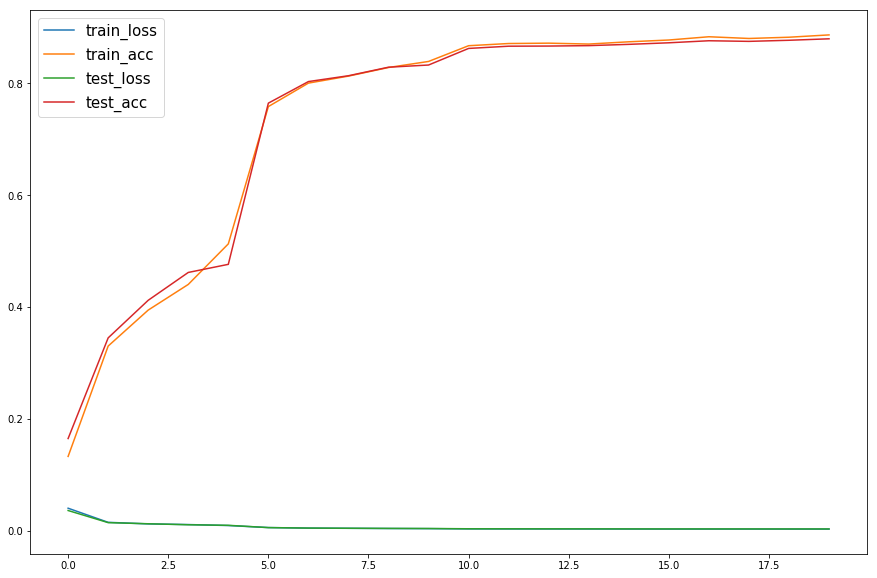

In [11]:
plt.figure(figsize=(15,10))
for phase in ('train', 'test'):
    plt.plot(range(len(epoch_loss[phase])), epoch_loss[phase], label=(phase + '_loss'))
    plt.plot(range(len(epoch_acc[phase])), epoch_acc[phase], label=(phase + '_acc'))
plt.legend(prop={'size': 15})

### Visualize predicting result

In [12]:
model.load_state_dict(best_model_state)
model = model.cpu()

[ 57.  66. 313. 232.]
[500. 333.]


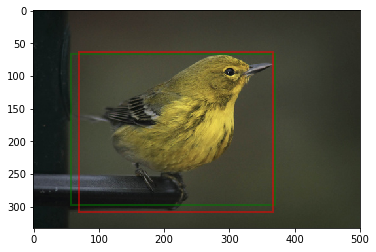

In [15]:
ind = random.choice(range(len(datasets['test'])))
im, box, im_size = datasets['test'][ind]
path, _ = datasets['test'].imgs[ind]
print(box)
print(im_size)
box = box_transform(box, im_size)[0]
#print(im_size)
#print(box)


pred_box = model(Variable(im.unsqueeze(0))).data[0]

ori_im = np.array(Image.open(path))

inp = im.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)

imshow(ori_im, box, pred_box)